In [82]:
# Rewrite this so it's just a single package to load
suppressMessages(require(tidyverse))
suppressMessages(require(magrittr))
suppressMessages(require(logspline))
suppressMessages(require(patchwork))
suppressMessages(require(IRdisplay))

# Introduction

The aim of this course is to give you an introduction to Bayesian statistics. It is by no means intended to be an exhaustive course, so at the end of it there will still be a lot for you to learn. However, I do hope that at the end of this workshop you’ll have a better understanding of Bayesian statistics, how it differs from Frequentist approaches, and how to incorporate some Bayesian approaches into your own research. 

The course will cover a number of topics including the foundations of Frequentist and Bayesian approaches to statistics, how to calculate Bayes factors, Bayesian estimation, and Bayesian regression modelling. 

- [The *p* value](#the-p-value)

## *The p value* 

*The American Statistical Association (ASA) defines a p value as:*

> *the probabi*lity under a specified statistical model that a statistical summary of the data (e.g., the sample mean difference between two compared groups) would be equal to or more extreme than its observed value [@wasserstein2016, my emphasis]

While this is a perfectly acceptable definition it is maybe a little tricky to understand. The main reason for this is that the definition contains at least one *ill-defined concept* ("probability") and one tricky concept ("specified statistical model"). To understand what a *p* value really is, we're going to have to unpack both of these ideas. Along the way we're going to learn about some other concepts that will also help us understand *Bayesian* statistics. And a good grounding on Frequentist inference will also help use understand the distinction between Frequentist inference and Bayesian inference. 

### Understanding *p* values through simulation

In [93]:
# Understanding p values through simulation
set.seed(612) # Set the seed for reproducibility

run.exp = function(){
  # define function for running experiment
  
    # define characteristics of the population
    sample_size = 10; average = 0
    
    
    
  # generate a sample
  dev = runif(1,1,10); min_possible = 0 -dev; max_possible = 0 + dev
  this_sample = runif(sample_size, min_possible, max_possible)
  
  # make descriptive stats
  tibble::tibble(sample_mean = mean(this_sample), 
                 sample_sd = sd(this_sample), 
                 n = sample_size)  
}

future::plan("multiprocess") # Set to run in parallel
no_of_exps = 100000 # Set the number of experiments to run
all_exps <- furrr::future_map_dfr(1:no_of_exps, function(x) 
  run.exp() %>% dplyr::mutate(i = x)) # run the experiments

dplyr::glimpse(all_exps) # view the results

Observations: 100,000
Variables: 4
$ sample_mean <dbl> 1.425150218, 1.166585169, 0.515405304, 0.559386086, 0.218…
$ sample_sd   <dbl> 2.1659451, 3.0019120, 2.4244579, 2.7109392, 1.9137974, 2.…
$ n           <dbl> 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1…
$ i           <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17…


In [121]:
set.seed(151); X = rnorm(10, runif(1,-10,10), runif(1));

glue::glue("Our {length(X)} measurements are: {glue::glue_collapse(round(X,2),sep = '; ')}  
           Our $\\bar{{x}}$ = {round(mean(X),2)}  
           Our $s_\\bar{{x}}$ = {round(sd(X)/sqrt(length(X)),3)}  
This means that our scaled measurement, $t$ = {round(mean(X) / (sd(X)/sqrt(length(X))),3)}") %>% 
IRdisplay::display_markdown()

Our 10 measurements are: 0.25; -0.54; -0.51; -0.75; 0.27; -1.62; -1.29; -0.21; 0.17; -0.83  
           Our $\bar{x}$ = -0.51  
           Our $s_\bar{x}$ = 0.204  
This means that our scaled measurement, $t$ = -2.485

$t={\frac {\mu\, \sqrt{n}}{\sigma}}$

Warning message:
“Removed 1 rows containing missing values (geom_bar).”
Warning message:
“Removed 583 rows containing non-finite values (stat_bin).”


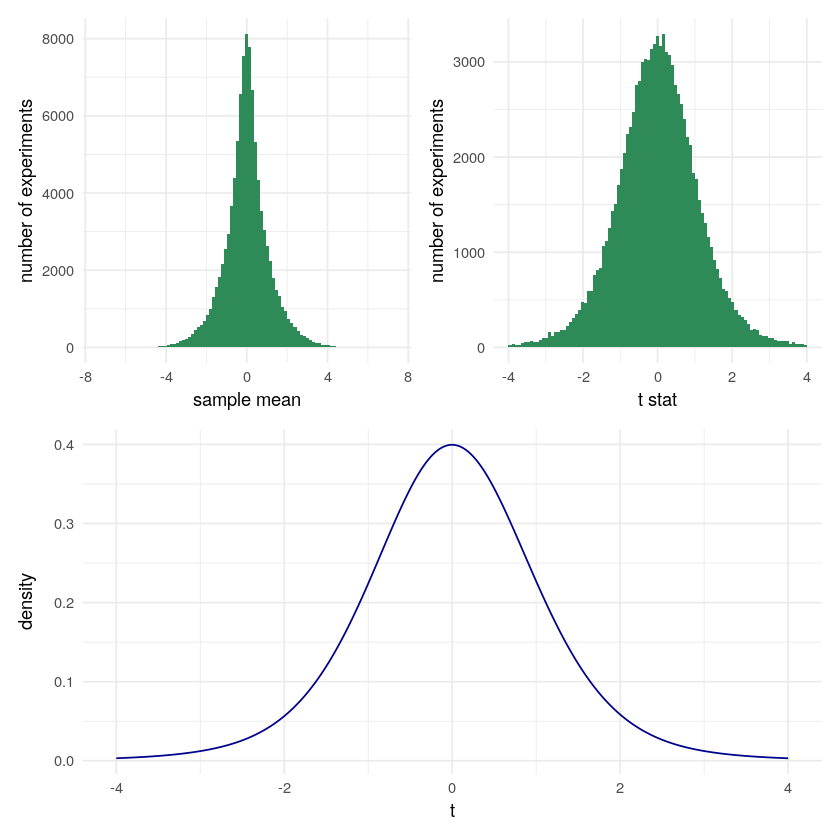

In [94]:
all_exps %<>% mutate(t = (sample_mean * sqrt(n)) / sample_sd)


all_exps %>% ggplot(aes(x = sample_mean)) + geom_histogram(fill = "seagreen",bins = 100) +
  labs(x = "sample mean", y = "number of experiments") + 
  xlim(c(-max(abs(all_exps$sample_mean)) * 1.10, max(abs(all_exps$sample_mean)) * 1.10)) +
  theme_minimal() -> mean_hist

all_exps %>% ggplot(aes(x = t)) + geom_histogram(fill = "seagreen", bins = 100) +
  labs(x = "t stat", y = "number of experiments") + xlim(c(-4,4)) +
  theme_minimal() -> t_hist

tibble(x = seq(-4, 4, length.out = 10000)) %>% 
  mutate(y = dlogspline(x,logspline(all_exps$t))) %>%
  ggplot(aes(x = x, y = y)) + geom_line(colour = "darkblue") +
  labs(x = "t", y = "density") + xlim(c(-4,4)) +
  theme_minimal() -> density_plot


(mean_hist | t_hist) / density_plot 



In [49]:
this_exp =rnorm(10, mean = 3, sd = 4)


In [50]:
t = (mean(this_exp) * sqrt(10)) / sd(this_exp)
t

[1] 2.3656

In [51]:
(all_exps$sample_mean > mean(this_exp)) %>% mean()

[1] 7e-05

In [35]:
  sample_size = 10; min_possible = -5; max_possible = 5
  this_sample = runif(sample_size, min_possible, max_possible)



[[1]]
[1] 0.1099401

[[2]]
[1] -4.364346

[[3]]
[1] 2.035492

[[4]]
[1] -3.147304

[[5]]
[1] 2.146921

[[6]]
[1] 0.4291014

[[7]]
[1] -3.020484

[[8]]
[1] -2.025721

[[9]]
[1] -3.167818

[[10]]
[1] 0.7365776

In [46]:
set.seed(612) # Set the seed for reproducibility
run.exp.trunc = function(){
  # define function for running experiment
  
  # define characteristics of the population
  sample_size = 10; min_possible = -5; max_possible = 5; trunc_at = 3
  
  # generate a sample
  this_sample = runif(sample_size, min_possible, max_possible)
  this_sample = map_dbl(this_sample, function(x) ifelse(x > trunc_at, trunc_at, x))
    
  # make descriptive stats
  tibble::tibble(sample_mean = mean(this_sample), 
                 sample_sd = sd(this_sample), 
                 n = sample_size)  
}

In [47]:
future::plan("multiprocess") # Set to run in parallel
no_of_exps = 100000 # Set the number of experiments to run
all_exps_trunc <- furrr::future_map_dfr(1:no_of_exps, function(x) 
  run.exp.trunc() %>% dplyr::mutate(i = x)) # run the experiments

dplyr::glimpse(all_exps_trunc) # view the results

Observations: 100,000
Variables: 4
$ sample_mean <dbl> -0.9728251, 0.1520450, 0.9774468, -0.7023351, 0.1637986, …
$ sample_sd   <dbl> 2.755097, 2.595596, 2.484868, 2.790967, 2.241521, 2.71295…
$ n           <dbl> 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1…
$ i           <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17…


In [58]:
set.seed(10); runif(n = 10, min = -1, max = 3) %>% t.test()


	One Sample t-test

data:  .
t = 2.2662, df = 9, p-value = 0.04967
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.000947656 1.068784716
sample estimates:
mean of x 
0.5348662 


In [89]:
all_exps %>% head() %>% knitr::kable() %>% as.character() %>% display_html()

sample_mean,sample_sd,n,i,t
-0.9728251,2.755098,10,1,-1.1166005
0.1520450,2.595596,10,2,0.1852401
0.9774468,2.484868,10,3,1.2439126
-0.7023351,2.790967,10,4,-0.7957738
0.1637986,2.241521,10,5,0.2310827
-0.1807060,2.712958,10,6,-0.2106345


# Heading

In [183]:
# testing our rule
set.seed(14) # set seed for reproducibly

Pr_treasure = runif(1) # Set the probablity of finding treasure

simulate_hunt <- function(Pr_treasure){
    
    # Decide whether this hunt has treasure
    has.treasure = ifelse(runif(1) < Pr_treasure, 1, 0) 
    
    X = rnorm(10, has.treasure, 1.5) # generate 10 readings
    
    # work out the scaled measurement and how suprising it is
    # and decide whether to dig or not!
    t.test(X) %>% broom::tidy() %>%
  mutate(has.treasure = ifelse(has.treasure == 1, "Y","N"), 
         how.suprising = p.value, 
         dig = ifelse(p.value < 0.05, "Y","N")) %>%
  select(has.treasure, dig)
    
}

set.seed(11) # set seed for reproducibly
furrr::future_map_dfr(1:100000, function(x) simulate_hunt(Pr_treasure)) -> test

In [184]:
test %>% slice(1:10) %>% knitr::kable() %>% as.character() %>% IRdisplay::display_html()

has.treasure,dig
Y,N
N,N
Y,Y
N,N
Y,Y
N,N
N,N
Y,N
N,Y
Y,N


[1] 0.2556

[1] 0.2540337

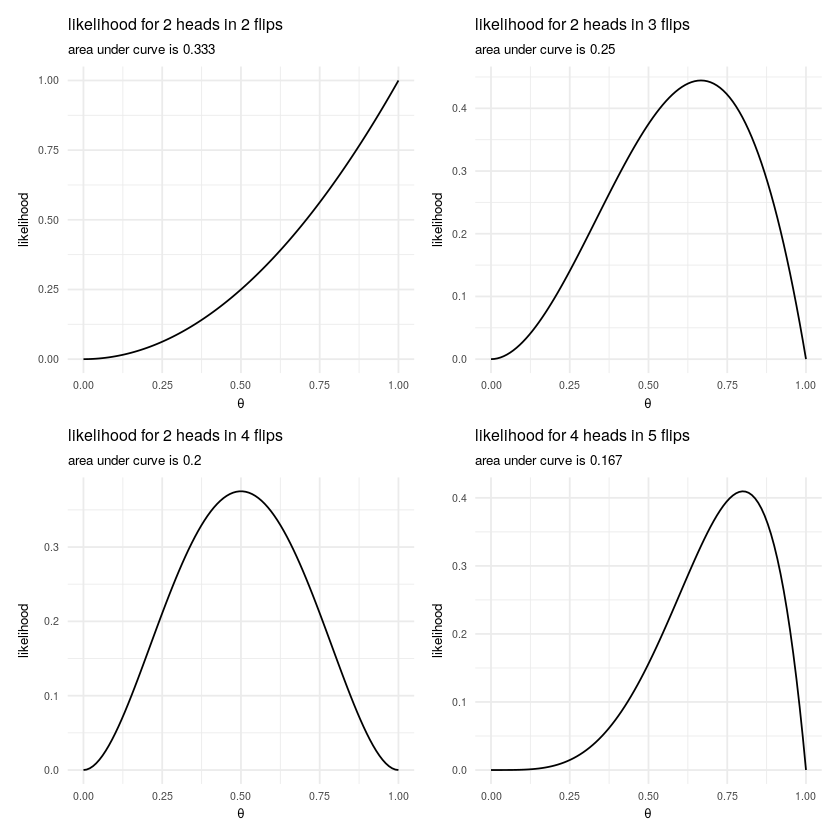

In [7]:
list(p1 = c(heads = 2, flips = 2),p2 = c(heads = 2, flips = 3),p3 = c(heads = 2, flips = 4),p4 = c(heads = 4, flips = 5)) -> scenarios
map(scenarios, function(x) {dbinom.like <- function(t) dbinom(x[["heads"]],x[["flips"]],t); integrate(dbinom.like,0,1)$value %>% tibble(heads = x[["heads"]], flips = x[["flips"]], auc = .)}) -> aucs
map(aucs, function(x) ggplot(mapping = aes(x = seq(0,1,length.out = 100), y = dbinom(x$heads,x$flips,seq(0,1,length.out = 100)))) + geom_line() + labs(y = "likelihood", x = "θ", title = glue::glue("likelihood for {x$heads} heads in {x$flips} flips"), subtitle = glue::glue("area under curve is {round(x$auc,3)}")) + theme_minimal() + theme(text = element_text(size = 8))) -> plots
(plots$p1 + plots$p2) / (plots$p3 + plots$p4) 